### GAN example for sample image production (with MNIST dataset)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [4]:
# A simple MLP GAN

# First component is the generator
class Generator(nn.Module):
    def __init__(self, latent_dim=64, img_dim=784):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, img_dim),
            nn.Tanh(), # c'est comme une sigmoïde, ça a valeur entre [-1, 1]
        )
        
    def forward(self, z):
        return self.model(z)
    
class Discriminator(nn.Module):
    def __init__(self, img_dim=784):
        super().__init__()
        self.model = nn.Sequential(
            # compression de l'image
            nn.Linear(img_dim, 512), 
            
            # couche d'activation
            # pourquoi une LeakyReLU et pas une ReLU:
            # on a en fait pour un ReLU classique:
            # ReLU(x)=max(0, x), si x négatif le gradient est nul, le neurone est "mort"
            # LeakyReLU(x)=max(0.2*x, x), si x est négatif le gradient est petit, ça évite les neurones morts
            # LEAKYRELU EVITE QUE LE DISCRIMINATOR DEVIENNE TROP CONFIANT ET ARRETE D'APPRENDRE
            nn.LeakyReLU(0.2),
            
            # nouvelle compression
            nn.Linear(512, 256),
            
            # couche d'activation
            nn.LeakyReLU(0.2),
            
            # score final
            nn.Linear(256, 1),
            
            # retourne une probabilité entre 0 et 1
            nn.Sigmoid(),
        )
    def forward(self, x):
        return self.model(x)

In [ ]:
# Training configuration
latent_dim = 64 # dimension du bruit d'entrée
batch_size = 128
lr = 2e-4 # les gans sont très sensibles au learning rate, s'il est grand on a instabilité, si trop petit l'apprentissage est trop lent
epochs = 3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_set = datasets.MNIST(root="./data", train=True, download=False, transform=transform)
loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

G = Generator(latent_dim=latent_dim).to(device)
D = Discriminator().to(device)

criterion = nn.BCELoss() # binary cross entropy loss
opt_G = optim.Adam(G.parameters(), lr=lr)
opt_D = optim.Adam(D.parameters(), lr=lr)

In [13]:
# Training tiiiime

for epoch in range(5):
    for i, (imgs, _) in enumerate(loader):
        imgs = imgs = imgs.view(imgs.size(0), -1).to(device)
        real_labels = torch.ones(imgs.size(0), 1).to(device)
        fake_labels = torch.zeros(imgs.size(0), 1).to(device)
        
        # training the discriminator
        # we train D to distinguish true images to fake images
        
        # on génère du bruit aléatoire
        z = torch.rand((imgs.size(0), latent_dim)).to(device)
        
        # on génère des fausses images
        fake_imgs = G(z).detach() # .detach() est important c'est pour que les gradients ne remontent pas dans G pendant l'entraînement de D
        
        D_real = D(imgs)
        D_fake = D(fake_imgs)
        
        # la loss totale du discrimator c'est celle pour reconnaître les vraies images + reconnaître les fausses images
        loss_D = criterion(D_real, real_labels) + criterion(D_fake, fake_labels)
        opt_D.zero_grad()
        loss_D.backward()
        opt_D.step()
        
        
        
        # training the generator
        # on entraîne G à tromper le discrimateur
        z = torch.randn(imgs.size(0), latent_dim).to(device)
        generated = G(z) # on génère de nouvelles fausses images
        D_generated = D(generated) # le discriminateur évalue ces images
        
        loss_G = criterion(D_generated, real_labels) # on veut que D pense que mes images sont vraient (qu'il se trompe en gros)
        opt_G.zero_grad()
        loss_G.backward()
        opt_G.step()
        
    print(f"Epoch [{epoch+1}/{epochs}] Loss D: {loss_D.item():.4f} Loss G: {loss_G.item():.4f}")

Epoch [1/3] Loss D: 0.0425 Loss G: 4.3936
Epoch [2/3] Loss D: 0.0706 Loss G: 10.8694
Epoch [3/3] Loss D: 0.0721 Loss G: 5.1577
Epoch [4/3] Loss D: 0.0558 Loss G: 4.0269
Epoch [5/3] Loss D: 0.0808 Loss G: 6.0997


Au début de l'entraînement:
- loss de D est élevée car D ne sait pas distinguer les vraies images des fausses
- loss de G est aussi élevée car G génère du bruit

Ensuite:
- loss de D baisse car D apprend à discriminer les vraies images des fausses
- loss de G monte car le générateur a plus de mal à tromper D

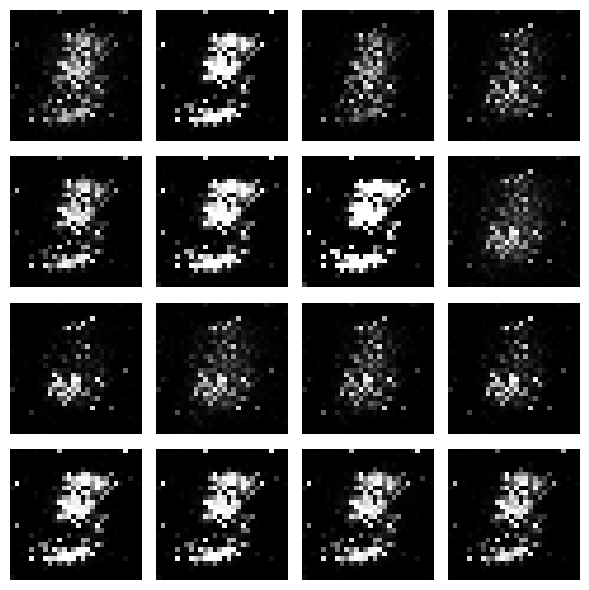

In [15]:
# image generation example

import matplotlib.pyplot as plt


G.eval()
with torch.no_grad():
    z = torch.randn(16, latent_dim).to(device)
    samples = G(z).cpu().view(-1, 28, 28)


plt.figure(figsize=(6,6))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(samples[i], cmap="gray")
    plt.axis("off")
plt.tight_layout()
plt.show()

# I don't try to optimize the model, I just try to understand its structure and the way it itnernally works

Problèmes courants des Gans:

I - Mode Collapse
Le générateur génère toujours la même image (ou quelques-unes), c'est causé par G qui trouve un moyen (en gros un cheat code) pour tromper D facilement

II - Vanishing gradients
Si D devient trop bon trop vite:
- D(G(z)) tend vers 0, D arrête d'apprendre
- Les gradients de G tendent aussi vers 0
- G arrête donc d'apprendre !

III - Oscillations des losses
C'est la vie

**Solutions:**
- Ajuster les learning rates
- Entrainer le discriminateur plusieurs fois avant chaque update de G
- Utiliser des architectures plus stables (WGAN, StyleGAN)

Comment la pipeline fonctionne:

epoch 1, batch 1:

charger 128 vraies images 
générer 128 fasses images avec le G
entrainer D: D(vraies) donne 1, D(fausses) donne 0
générer 128 nouvelles fausses images
entrainer G: D(G(z)) donne 1 (il faut tromper D)

epoch 1, batch 2:
etc etc